<a href="https://colab.research.google.com/github/dirudiez/TFM_DiegoRudiez/blob/main/autoencoder/AutoencoderKaggle_pyimagesearch_128.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Librerías

In [ ]:
import PIL
import cv2
import os

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

## Descarga de Datos

Nos descargamos las imágenes con un ancho de 256 de ancho. Vamos a ir escalando a 64, 128 y 256. Lo haremos con cv2.resize()

### Kaggle

**Descargamos un dataset de kaggle para aumentar el número de imágenes de prueba**

Tiene las siguientes clases:

*   0 - No DR
*   1 - Mild
*   2 - Moderate
*   3 - Severe
*   4 - Proliferative DR


A nosotros nos intersan las de la clase 0. 







In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"diegorudiezgomez","key":"a97ea3f0837ef30e1012d50ea0d74929"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
 ! chmod 600 ~/.kaggle/kaggle.json

**Tras relizar algunas configuraciones descargamos el dataset:**

In [ ]:
%%time
! kaggle competitions download -c 'aptos2019-blindness-detection'

100% 9.49G/9.51G [03:13<00:00, 43.1MB/s]
100% 9.51G/9.51G [03:13<00:00, 52.7MB/s]
CPU times: user 1.88 s, sys: 333 ms, total: 2.21 s
Wall time: 3min 15s


In [ ]:
!unzip -qq aptos2019-blindness-detection.zip -d 'datasetKaggle'

In [ ]:
datasetKaggle = 'datasetKaggle'

In [ ]:
imgTrain = os.listdir(datasetKaggle + '/train_images')

In [ ]:
datasetKaggle + '/train_images/' + imgTrain[0]

'datasetKaggle/train_images/99e8bf998285.png'

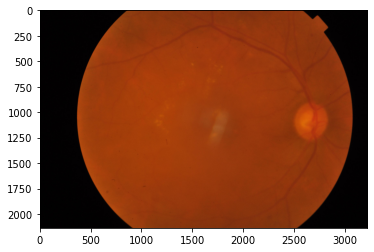

In [ ]:
image = cv2.imread(datasetKaggle + '/train_images/' + imgTrain[0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [ ]:
df_trainKaggle = pd.read_csv(datasetKaggle + '/train.csv')

In [ ]:
df_trainKaggle['diagnosis'].value_counts() #1805 imágenes sanas

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

In [ ]:
df_trainKaggle.head(5)

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


### Reto

**Ahora las del reto que hemos utilizado siempre.**

In [ ]:
# !wget https://www.dropbox.com/s/o1eaoae59qgdo4i/Training_Set_Pre.zip?dl=0 --no-verbose -O train.zip
# !wget https://www.dropbox.com/s/5od5cac9xhxlcwu/Test_Set_Pre.zip?dl=0 --no-verbose -O test.zip
# !wget https://www.dropbox.com/s/gjz445xm4oddfus/Evaluation_Set_Pre.zip?dl=0 --no-verbose -O val.zip

In [ ]:
# !rm -rvf Training_Set_Pre
# !unzip -qq train.zip #-qq no verbose
# !unzip -qq test.zip
# !unzip -qq val.zip

Descargamos el dataset sin procesar, para aplicar el mismo procesado a los dos datsets

In [ ]:
!wget https://www.dropbox.com/s/1isaa8xrrv0x6n4/datasetComprimido.zip?dl=0 --no-verbose -O datasetComp.zip

2022-06-27 17:29:05 URL:https://uc2f325969d8172a65a4eac69995.dl.dropboxusercontent.com/cd/0/inline2/BoCCJ9OpWueW5BfwGVNM1EORa0EbUAu6Vt2ekyKLIABu6Ufxvn9MGwDAHRqgdhoXZxT_gvY4XxEL_z_xbCR-LKjSIWkquBiGaMxXxlFecNrfKdq5ICrdu4cy2T7huXPwuYNC7-Sx2cQ864eXovo4rH1HsawlOdE6IhM3gjFjoAL57HBYDgzdjgs7miUcal9jtLdkZ-74d0USWUPByKkgQ0wDV2ndsFWh3xCVrqRu_QA3hNAWILZCRAPnPWY0jPCEUTQUUFisVf-wNiiTNKyss2jz2V03UAYjAAL_0jnW1sEC_ddohIzlCMYSZc9RPaX3KVnvHJrpdTytPxsIlWLyjcd92sTSFdzL921UvWuCgKqpoWL6eq4y2zF5yKMwzr52MNFplPSgetRPz1Zv00DPCwhf_CQOo43JKuBtD3-JaJ-5iQ/file [144922725/144922725] -> "datasetComp.zip" [1]


In [ ]:
!unzip -qq datasetComp.zip

In [ ]:
# trainPath = 'Training_Set_Pre/'
# testPath  = 'Test_Set_Pre/'
# valPath  =  'Evaluation_Set_Pre/'

In [ ]:
trainPath = 'Training_Set_C/'
testPath  = 'Test_Set_C/'
valPath  =  'Evaluation_Set_C/'

## Preparación de Datos

In [ ]:
IMG_SIZE = 128

### Funciones de procesado

In [ ]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

def load_ben_color(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted(image,4, cv2.GaussianBlur(image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

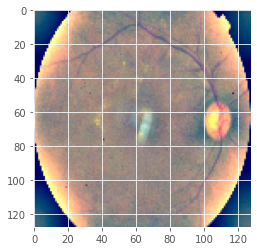

In [ ]:
img = load_ben_color(datasetKaggle + '/train_images/' + imgTrain[0])
plt.imshow(img)

### Datos Kaggle

In [ ]:
import shutil

def getNpArrayKaggle(df, pathO):
  normal, enfermedad = [], []
  for id, enf in zip(df['id_code'], df['diagnosis']):
    # image = load_ben_color(pathO + '/' + str(id) + '.png', sigmaX=30)
    if(int(enf)==0):
      image = load_ben_color(pathO + '/' + str(id) + '.png')
      normal.append(np.asarray(image))
    # else:
    #   enfermedad.append(np.asarray(image))
  return np.array(normal), np.array(enfermedad)

In [ ]:
normalKaggle, enfermedadKaggle = getNpArrayKaggle(df_trainKaggle, datasetKaggle + '/train_images')

In [ ]:
normalKaggle.shape

(1805, 128, 128, 3)

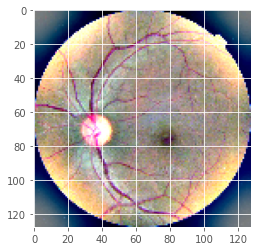

In [ ]:
plt.imshow(normalKaggle[0])

### Datos Reto (el mismo de siempre)


In [ ]:
import shutil

def getNpArray(df, pathO):
  normal, enfermedad = [], []
  for id, enf in zip(df['ID'], df['Disease_Risk']):
    image = load_ben_color(pathO + '/' + str(id) + '.png')
    if(int(enf)==0):
      normal.append(np.asarray(image))
    else:
      enfermedad.append(np.asarray(image))
  return np.array(normal), np.array(enfermedad)

In [ ]:
df_train = pd.read_csv(trainPath + '/train.csv')
df_test = pd.read_csv(testPath + '/test.csv')
df_val = pd.read_csv(valPath + '/val.csv')

In [ ]:
normalTrain, enfermedadTrain = getNpArray(df_train, trainPath + 'Training/')
normalTest, enfermedadTest = getNpArray(df_test, testPath + 'Test/')
normalVal, enfermedadVal = getNpArray(df_val, valPath + 'Validation/')

In [ ]:
normalTrain.shape

(401, 128, 128, 3)

In [ ]:
normalTest.shape

(134, 128, 128, 3)

Ya la tenemos reescalada a la medida deseada:

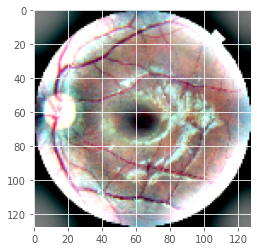

In [ ]:
plt.imshow(normalTrain[0])

**Concatenamos los datos**

In [ ]:
normalTrain  = np.concatenate([normalTrain, normalKaggle])

Ahora los normalizamos

In [ ]:
normalTrain = normalTrain.astype('float32') / 255.
enfermedadTrain = enfermedadTrain.astype('float32') / 255.

normalVal = normalVal.astype('float32') / 255.
enfermedadVal = enfermedadVal.astype('float32') / 255.

normalTest = normalTest.astype('float32') / 255.
enfermedadTest = enfermedadTest.astype('float32') / 255.

## Autoencoder pyimagesearch

https://pyimagesearch.com/2020/03/02/anomaly-detection-with-keras-tensorflow-and-deep-learning/

In [ ]:
# import the necessary packages
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np
class ConvAutoencoder:
	@staticmethod
	def build(width, height, depth, filters=(32, 64), latentDim=16):
		# initialize the input shape to be "channels last" along with
		# the channels dimension itself
		# channels dimension itself
		inputShape = (height, width, depth)
		chanDim = -1
		# define the input to the encoder
		inputs = Input(shape=inputShape)
		x = inputs
		# loop over the number of filters
		for f in filters:
			# apply a CONV => RELU => BN operation
			x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)
		# flatten the network and then construct our latent vector
		volumeSize = K.int_shape(x)
		x = Flatten()(x)
		latent = Dense(latentDim)(x)
		# build the encoder model
		encoder = Model(inputs, latent, name="encoder")
		# start building the decoder model which will accept the
		# output of the encoder as its inputs
		latentInputs = Input(shape=(latentDim,))
		x = Dense(np.prod(volumeSize[1:]))(latentInputs)
		x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)
		# loop over our number of filters again, but this time in
		# reverse order
		for f in filters[::-1]:
			# apply a CONV_TRANSPOSE => RELU => BN operation
			x = Conv2DTranspose(f, (3, 3), strides=2,
				padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)
		# apply a single CONV_TRANSPOSE layer used to recover the
		# original depth of the image
		x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
		outputs = Activation("sigmoid")(x)
		# build the decoder model
		decoder = Model(latentInputs, outputs, name="decoder")
		# our autoencoder is the encoder + decoder
		autoencoder = Model(inputs, decoder(encoder(inputs)),
			name="autoencoder")
		# return a 3-tuple of the encoder, decoder, and autoencoder
		return (encoder, decoder, autoencoder)

### Creación de Datos (No lo necesitamos)

In [ ]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")
# import the necessary packages
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import pickle
import cv2

def build_unsupervised_dataset(data, labels, validLabel=1,
	anomalyLabel=3, contam=0.01, seed=42):
	# grab all indexes of the supplied class label that are *truly*
	# that particular label, then grab the indexes of the image
	# labels that will serve as our "anomalies"
	validIdxs = np.where(labels == validLabel)[0]
	anomalyIdxs = np.where(labels == anomalyLabel)[0]
	# randomly shuffle both sets of indexes
	random.shuffle(validIdxs)
	random.shuffle(anomalyIdxs)
	# compute the total number of anomaly data points to select
	i = int(len(validIdxs) * contam)
	anomalyIdxs = anomalyIdxs[:i]
	# use NumPy array indexing to extract both the valid images and
	# "anomlay" images
	validImages = data[validIdxs]
	anomalyImages = data[anomalyIdxs]
	# stack the valid images and anomaly images together to form a
	# single data matrix and then shuffle the rows
	images = np.vstack([validImages, anomalyImages])
	np.random.seed(seed)
	np.random.shuffle(images)
	# return the set of images
	return images

In [ ]:
def visualize_predictions(decoded, gt, samples=10):
	# initialize our list of output images
	outputs = None
	# loop over our number of output samples
	for i in range(0, samples):
		# grab the original image and reconstructed image
		original = (gt[i] * 255).astype("uint8")
		recon = (decoded[i] * 255).astype("uint8")
		# stack the original and reconstructed image side-by-side
		output = np.hstack([original, recon])
		# if the outputs array is empty, initialize it as the current
		# side-by-side image display
		if outputs is None:
			outputs = output
		# otherwise, vertically stack the outputs
		else:
			outputs = np.vstack([outputs, output])
	# return the output images
	return outputs

In [ ]:
# # construct the argument parse and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-d", "--dataset", type=str, required=True,
# 	help="path to output dataset file")
# ap.add_argument("-m", "--model", type=str, required=True,
# 	help="path to output trained autoencoder")
# ap.add_argument("-v", "--vis", type=str, default="recon_vis.png",
# 	help="path to output reconstruction visualization file")
# ap.add_argument("-p", "--plot", type=str, default="plot.png",
# 	help="path to output plot file")
# args = vars(ap.parse_args())

In [ ]:
images = build_unsupervised_dataset(normalKaggle, '', validLabel=1, anomalyLabel=3, contam=0.01)

# add a channel dimension to every image in the dataset, then scale
# the pixel intensities to the range [0, 1]
images = np.expand_dims(images, axis=-1)
images = images.astype("float32") / 255.0

In [ ]:
images.shape

(0, 128, 128, 3, 1)

### Creación Autoencoder

In [ ]:
EPOCHS = 40
INIT_LR = 1e-3
BS = 32

# construct our convolutional autoencoder
print("[INFO] building autoencoder...")
(encoder, decoder, autoencoder) = ConvAutoencoder.build(IMG_SIZE, IMG_SIZE, 3)
opt = Adam(lr= INIT_LR, decay= INIT_LR / EPOCHS)
autoencoder.compile(loss="binary_crossentropy", optimizer=opt)

[INFO] building autoencoder...


In [ ]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 64, 64, 32)        0         
                                                                 
 batch_normalization_4 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                           

In [ ]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 16)]              0         
                                                                 
 dense_3 (Dense)             (None, 65536)             1114112   
                                                                 
 reshape_1 (Reshape)         (None, 32, 32, 64)        0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 64, 64, 64)       36928     
 ranspose)                                                       
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 64, 64, 64)        0         
                                                                 
 batch_normalization_6 (Batc  (None, 64, 64, 64)       256       
 hNormalization)                                           

### Entrenamiento

In [ ]:
# train the convolutional autoencoder
H = autoencoder.fit(
	normalTrain, normalTrain,
	validation_data=(normalVal, normalVal),
	epochs=EPOCHS,
	batch_size=BS)

Epoch 1/40
69/69 [==============================] - 5s 56ms/step - loss: 0.6324 - val_loss: 0.6592
Epoch 2/40
69/69 [==============================] - 3s 45ms/step - loss: 0.6019 - val_loss: 0.6601
Epoch 3/40
69/69 [==============================] - 3s 45ms/step - loss: 0.5977 - val_loss: 0.6568
Epoch 4/40
69/69 [==============================] - 3s 45ms/step - loss: 0.5943 - val_loss: 0.6434
Epoch 5/40
69/69 [==============================] - 3s 45ms/step - loss: 0.5915 - val_loss: 0.6346
Epoch 6/40
69/69 [==============================] - 3s 45ms/step - loss: 0.5894 - val_loss: 0.6185
Epoch 7/40
69/69 [==============================] - 3s 45ms/step - loss: 0.5882 - val_loss: 0.6072
Epoch 8/40
69/69 [==============================] - 3s 45ms/step - loss: 0.5874 - val_loss: 0.6051
Epoch 9/40
69/69 [==============================] - 3s 45ms/step - loss: 0.5867 - val_loss: 0.5918
Epoch 10/40
69/69 [==============================] - 3s 44ms/step - loss: 0.5861 - val_loss: 0.5878
Epoch 11/

### Evaluación

In [ ]:
from google.colab.patches import cv2_imshow

# make predictions on our image data and initialize our list of
# reconstruction errors

def test(autoencoder, data):
  decoded = autoencoder.predict(data)
  errors = []
  for (image, recon) in zip(data, decoded):
    mse = np.mean((image - recon) ** 2)
    errors.append(mse)
  thresh = np.quantile(errors, 0.999)
  idxs = np.where(np.array(errors) >= thresh)[0]
  return len(data)-len(idxs), len(idxs)

In [ ]:
def calcularMetricas(TN, FP, FN ,TP):
  print("Accuracy:  ", ((TP + TN)/(TP + TN + FP + FN)))
  recall = (TP/(TP + FN))
  print("Recall :   ", recall)
  precision = (TP/(TP + FP))
  print("Precisión: ", precision)
  print("F1-Score:  ", (2 * precision * recall)/(precision + recall))

In [ ]:
TN, FP = test(autoencoder, normalTest) #TN y FP
FN, TP = test(autoencoder, enfermedadTest) #FN y TP
calcularMetricas(TN, FP, FN ,TP)

Accuracy:   0.209375
Recall :    0.001976284584980237
Precisión:  0.5
F1-Score:   0.003937007874015748


[INFO] mse threshold: 0.04789325634017597
[INFO] 1 outliers found


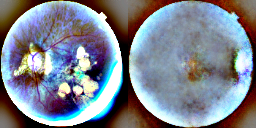

-1

In [ ]:
from google.colab.patches import cv2_imshow

# make predictions on our image data and initialize our list of
# reconstruction errors
decoded = autoencoder.predict(enfermedadTest)
errors = []
# loop over all original images and their corresponding
# reconstructions
for (image, recon) in zip(enfermedadTest, decoded):
	# compute the mean squared error between the ground-truth image
	# and the reconstructed image, then add it to our list of errors
	mse = np.mean((image - recon) ** 2)
	errors.append(mse)
# compute the q-th quantile of the errors which serves as our
# threshold to identify anomalies -- any data point that our model
# reconstructed with > threshold error will be marked as an outlier
thresh = np.quantile(errors, 0.999)
idxs = np.where(np.array(errors) >= thresh)[0]
print("[INFO] mse threshold: {}".format(thresh))
print("[INFO] {} outliers found".format(len(idxs)))
# initialize the outputs array
outputs = None
# loop over the indexes of images with a high mean squared error term
for i in idxs:
	# grab the original image and reconstructed image
	original = (enfermedadTest[i] * 255).astype("uint8")
	recon = (decoded[i] * 255).astype("uint8")
	# stack the original and reconstructed image side-by-side
	output = np.hstack([original, recon])
	# if the outputs array is empty, initialize it as the current
	# side-by-side image display
	if outputs is None:
		outputs = output
	# otherwise, vertically stack the outputs
	else:
		outputs = np.vstack([outputs, output])
# show the output visualization
cv2_imshow(outputs)
cv2.waitKey(0)

[INFO] making predictions...


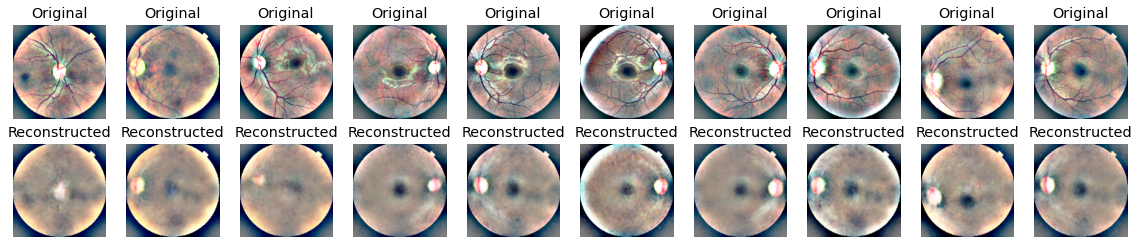

In [ ]:
# use the convolutional autoencoder to make predictions on the
# testing images, construct the visualization, and then save it
# to disk
print("[INFO] making predictions...")
decoded = autoencoder.predict(normalTest)
# vis = visualize_predictions(decoded, normalTest)
# cv2.imwrite(args["vis"], vis)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(normalTest[i].reshape(IMG_SIZE, IMG_SIZE,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    plt.title("Original")
    ax.get_yaxis().set_visible(False)
    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.title("Reconstructed")
    plt.imshow(decoded[i].reshape(IMG_SIZE, IMG_SIZE,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

[INFO] making predictions...


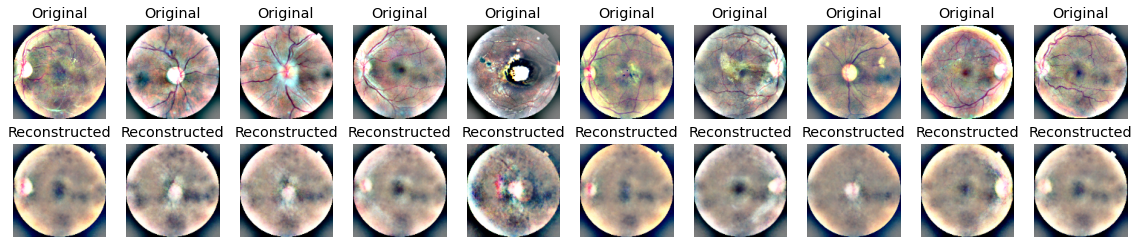

In [ ]:
# use the convolutional autoencoder to make predictions on the
# testing images, construct the visualization, and then save it
# to disk
print("[INFO] making predictions...")
decoded = autoencoder.predict(enfermedadTest)
# vis = visualize_predictions(decoded, normalTest)
# cv2.imwrite(args["vis"], vis)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(enfermedadTest[i].reshape(IMG_SIZE, IMG_SIZE,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    plt.title("Original")
    ax.get_yaxis().set_visible(False)
    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.title("Reconstructed")
    plt.imshow(decoded[i].reshape(IMG_SIZE, IMG_SIZE,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

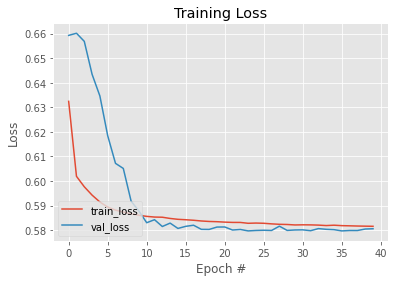

In [ ]:
# construct a plot that plots and saves the training history
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")